In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

# Functions

## LIF module

In [12]:
class LIF(torch.nn.Module):

    def __init__(self,R,tau,u_rest,threshold):
        """
        Args:
            R : Circuit resistance equivalent to neuron gates (MΩ)
            tau : Time constant of the neuron (mS)
            u_rest : Resting potential of the neuron (mV)
            threshold : spiking threshold of the neuron (mV)
        """
        super(LIF, self).__init__()
        self.R=R
        self.tau=tau
        self.u=u_rest
        self.u_rest=u_rest
        self.threshold=threshold
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
    
    def forward(self,x):
        dt = x[0] - self.time
        self.time = x[0]
        du=dt*(-1*(self.u-self.u_rest)+self.R*x[1])/self.tau
        self.u +=du
        if self.u>self.threshold:
            self.to_rest()
            self.history = torch.vstack((self.history,torch.tensor([self.time,self.u])))
            return torch.tensor([[self.time,1]])
        else : 
            self.history = torch.vstack((self.history,torch.tensor([self.time,self.u])))
            return torch.tensor([[self.time,0]])
        
    def reset(self):
        self.u=self.u_rest
        self.time = 0
        self.history = torch.tensor([self.time,self.u])
        
    
    def to_rest(self):
        self.u=self.u_rest

In [13]:
def process(model,dataloader):
    spikes_data =None 
    for data in dataloader:
        result = model(data[0])
        if spikes_data is None:
            spikes_data = result
        else : 
            spikes_data = torch.vstack((spikes_data,result))
    return spikes_data

## Data loading

In [14]:
class CurrentDataset(torch.utils.data.Dataset):
    """current dataset"""

    def __init__(self,data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[idx].values
        return torch.tensor(sample)

## Implementing plots

In [15]:
def plot_spikes(spikes):
    spike_points = spikes[spikes[:,1]==1.0]
    fig = plt.figure(figsize=(10,5))
    plt.scatter(spike_points[:,0],spike_points[:,1],marker='|',c='r',s=500)
    plt.xlabel("time (mS)")
    plt.yticks(ticks=[1],labels=['spike'])
    plt.grid()
    plt.title("Spike points diagram")
    plt.show()

In [16]:
def plot_current(dataframe):
    fig = plt.figure(figsize=(8,5))
    plt.plot(dataframe.iloc[:,0],dataframe.iloc[:,1],c='r')
    plt.xlabel("time (mS)")
    plt.ylabel("current(pA)")
    plt.grid()
    plt.title("current diagram")
    plt.show()

In [17]:
def plot_frequencies(spikes, data):
  spike_points = spikes[spikes[:,1]==1.0]
  spike_frec = []
  spike_frec.append(0)
  spike_frec.append(0)
  for i in range(len(spike_points) - 1):
    spike_frec.append(1 / (spike_points[i + 1][0] - spike_points[i][0]))
  ones_indices = np.where(spikes[:, 1] == 1)[0]
  ones_indices = np.insert(ones_indices, 0, 0)
  t = []
  for i in ones_indices:
    t.append(data[1][i])
  res = []
  res.append(t)
  res.append(spike_frec)
  res = np.array(res)
  res = res [ :, res[0].argsort()]
  fig = plt.figure(figsize=(10,5))
  plt.plot(res[0],res[1])
  plt.xlabel("current(pA)")
  plt.ylabel("frequency(kHz)")
  plt.grid()
  plt.title("Spike frequency diagram")
  plt.show()

In [18]:
def plot_history(history):
    fig = plt.figure(figsize=(8,5))
    plt.plot(history[:,0],history[:,1],c='r')
    plt.xlabel("time (mS)")
    plt.ylabel("Voltage(mV)")
    plt.grid()
    plt.title("PSP diagram")
    plt.show()

## Run function to run everything with setted params

In [19]:
def run(data, R,tau,u_rest,threshold):
  """
  Args:
      data : Data as a pandas Dataframne
      R : Circuit resistance equivalent to neuron gates (MΩ)
      tau : Time constant of the neuron (mS)
      u_rest : Resting potential of the neuron (mV)
      threshold : spiking threshold of the neuron (mV)
  """
  model = LIF(R,tau,u_rest,threshold)
  dataset = CurrentDataset(data)
  linear_current_dataloader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
  spikes_information = process(model,linear_current_dataloader)
  plot_spikes(spikes_information)
  plot_history(model.history)
  plot_frequencies(spikes_information, data)
  model.reset()

# Constant current without noise

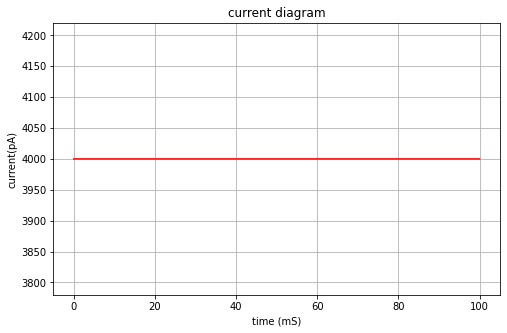

In [20]:
const_data = pd.read_csv('/content/const_current.csv')
const_data.rename(columns={"time(ms)": 0, "current(pA)": 1}, inplace=True)
plot_current(const_data)

## R=0.01, tau=8, u_rest=-65, threshold=-50

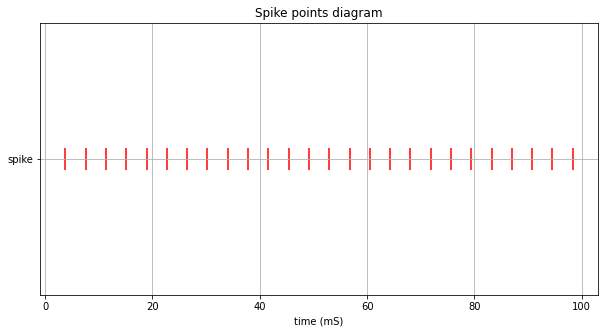

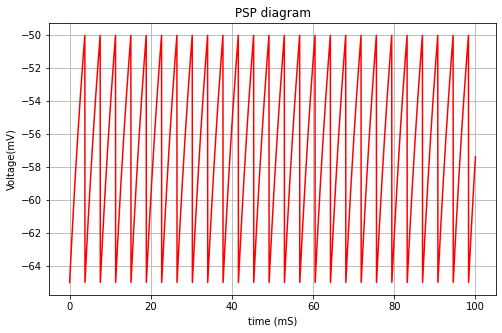

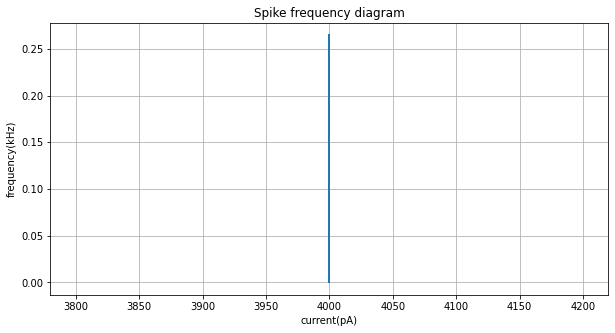

In [21]:
run(data=const_data, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

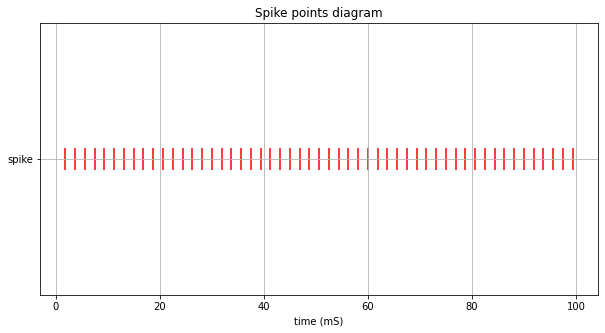

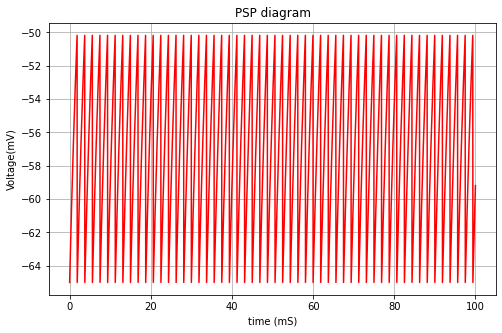

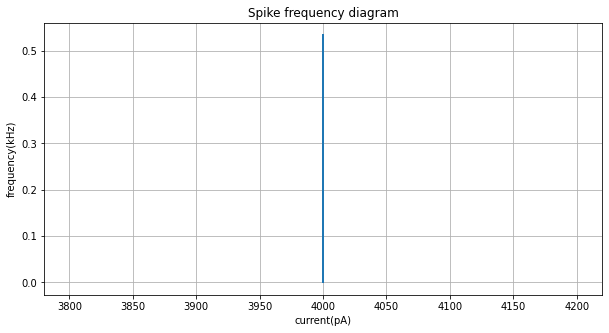

In [22]:
run(data=const_data, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

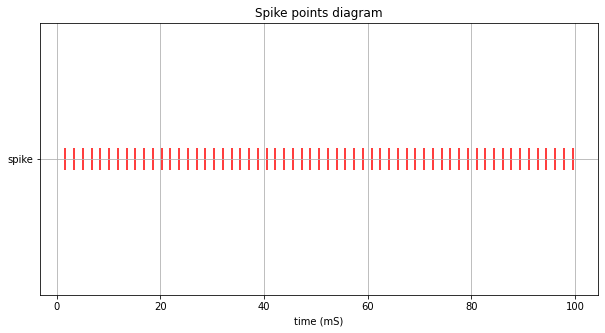

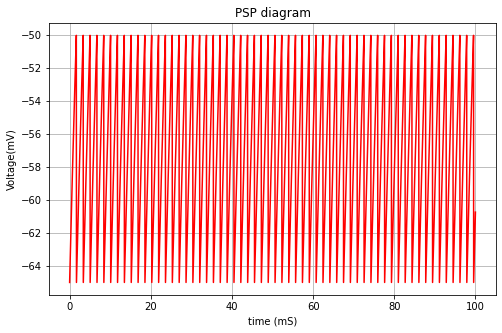

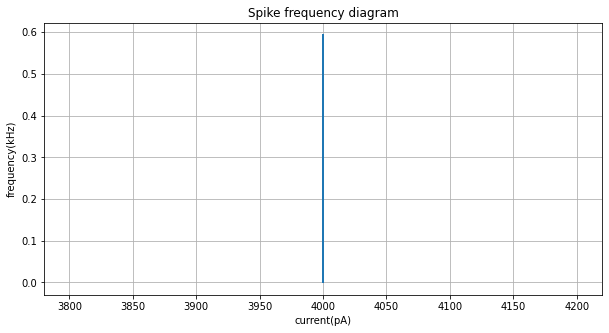

In [23]:
run(data=const_data, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

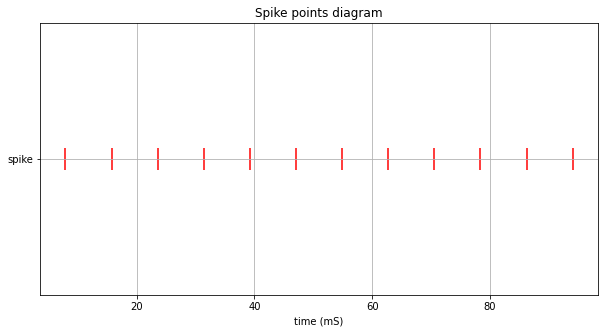

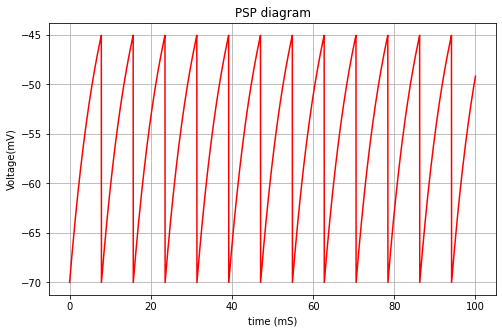

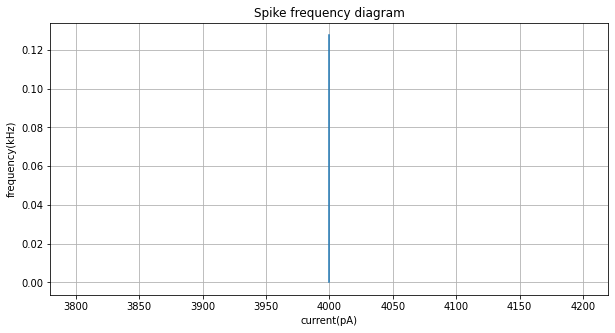

In [24]:
run(data=const_data, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

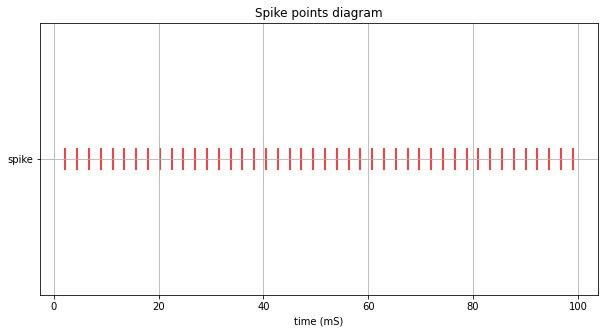

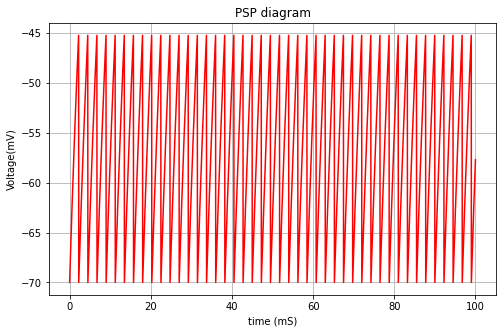

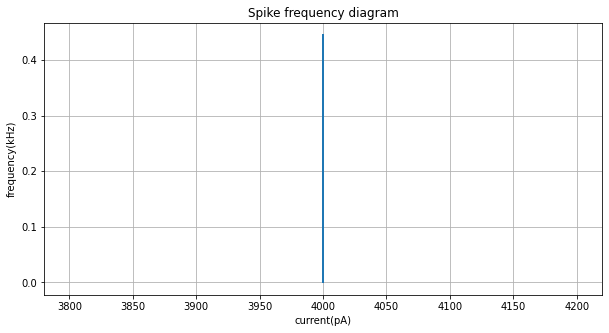

In [25]:
run(data=const_data, R=0.02, tau=6, u_rest=-70, threshold=-45)

# Constant current with noise

<ipython-input-26-201cad837c33>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noised_data_df[1][i] = noised_data_df[1][i] + random.uniform(-1*(noised_data_df[1][i]*0.05), noised_data_df[1][i]*0.05)


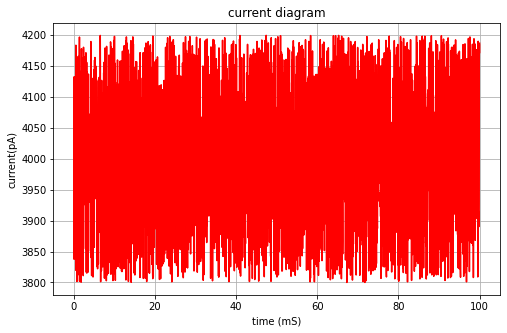

In [26]:
#making a noised floor dataset
noised_data_df = const_data.copy()
for i in range(len(noised_data_df)):
  noised_data_df[1][i] = noised_data_df[1][i] + random.uniform(-1*(noised_data_df[1][i]*0.05), noised_data_df[1][i]*0.05)
plot_current(noised_data_df)

## R=0.01, tau=8, u_rest=-65, threshold=-50

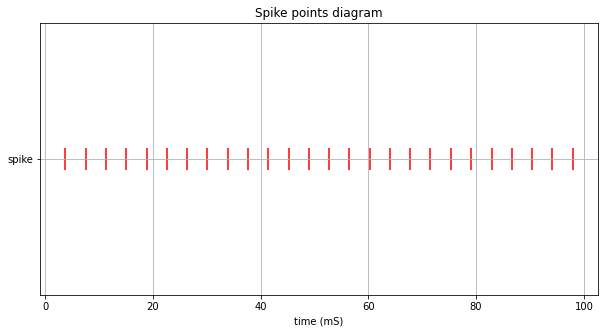

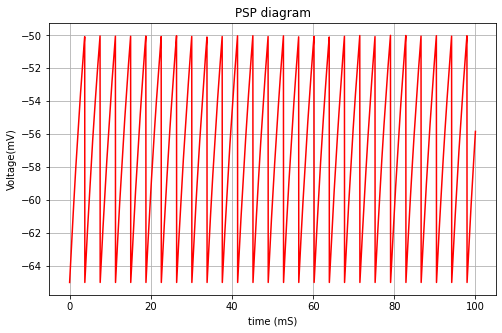

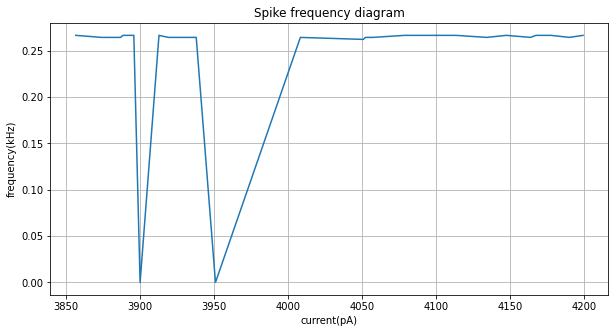

In [27]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

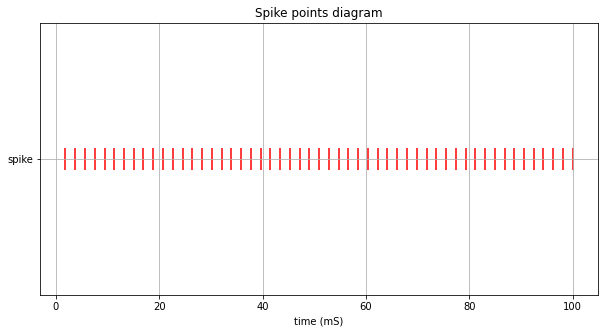

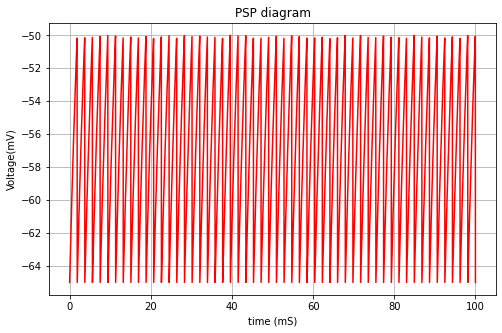

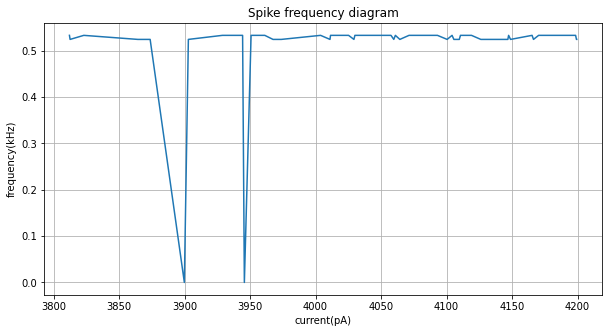

In [28]:
run(data=noised_data_df, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

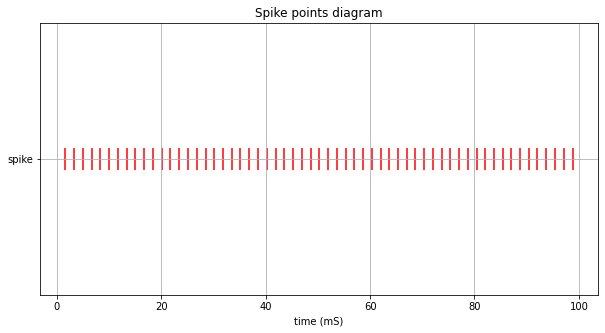

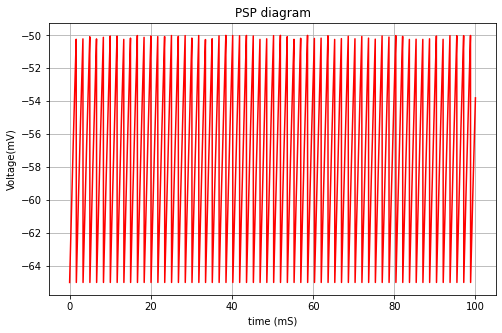

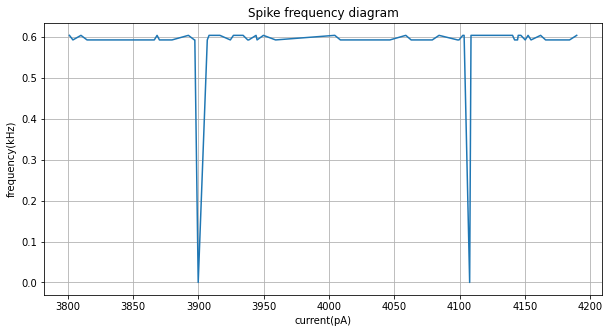

In [29]:
run(data=noised_data_df, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

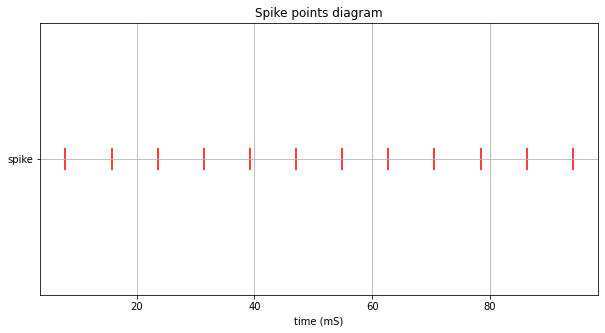

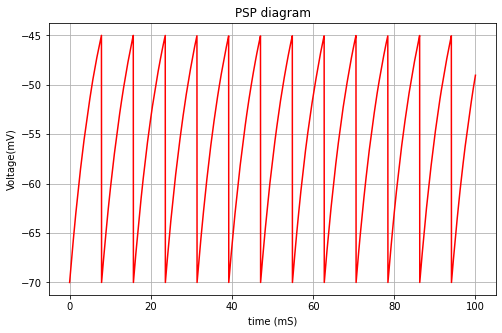

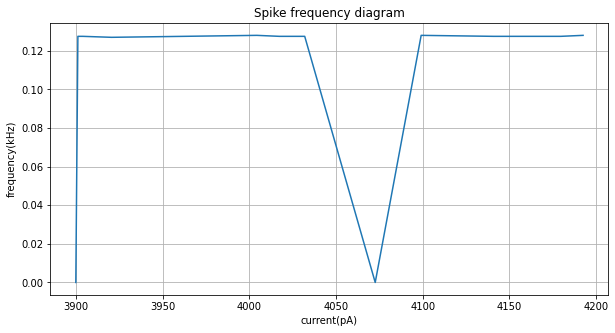

In [30]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

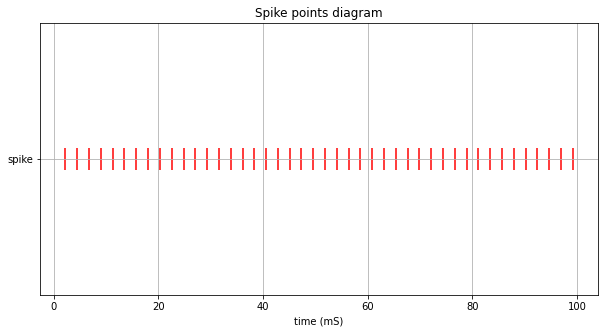

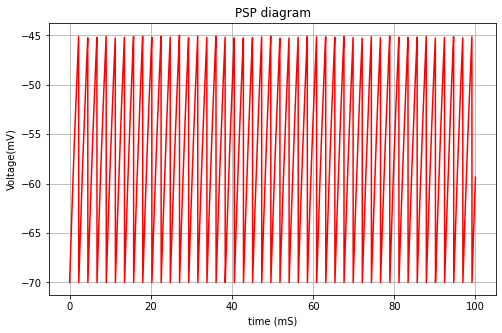

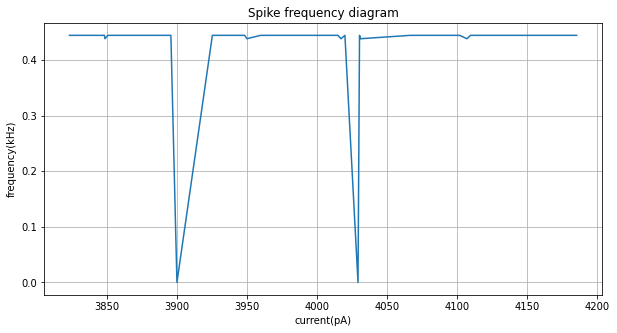

In [31]:
run(data=noised_data_df, R=0.02, tau=6, u_rest=-70, threshold=-45)

# Linear current without noise

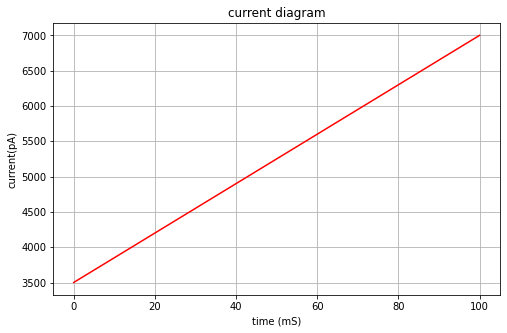

In [32]:
linear_data = pd.read_csv('/content/linear_current.csv')
linear_data.rename(columns={"time(ms)": 0, "current(pA)": 1}, inplace=True)
plot_current(linear_data)

## R=0.01, tau=8, u_rest=-65, threshold=-50

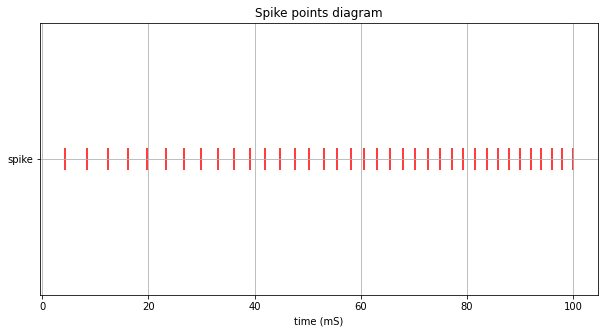

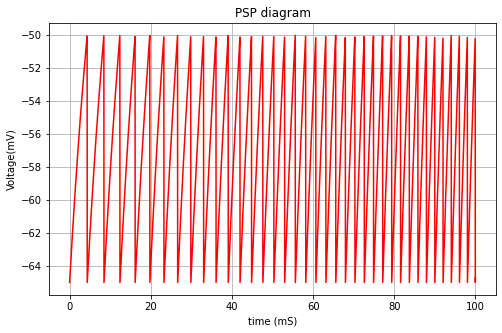

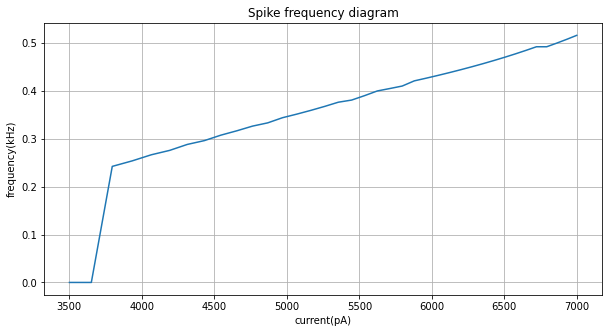

In [33]:
run(data=linear_data, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

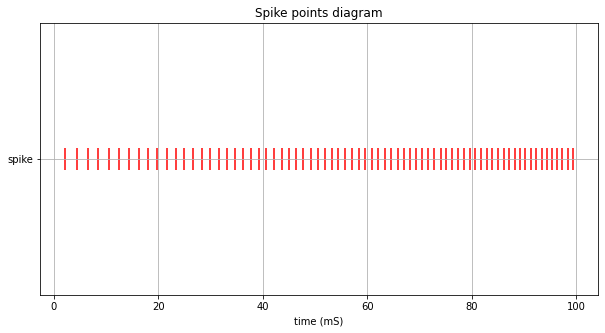

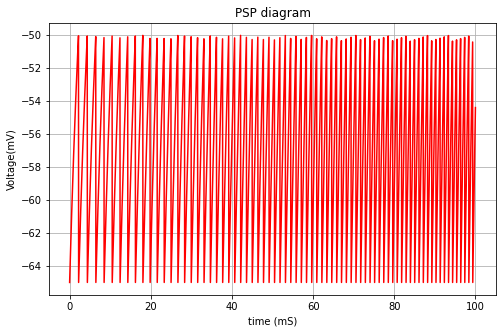

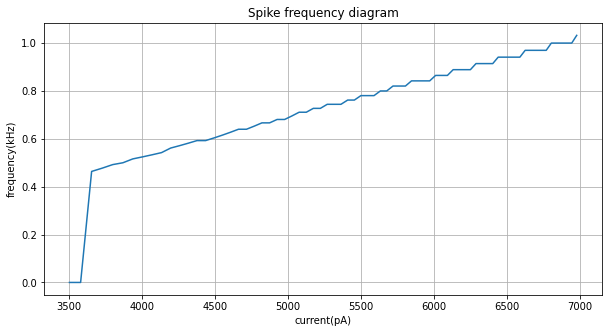

In [34]:
run(data=linear_data, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

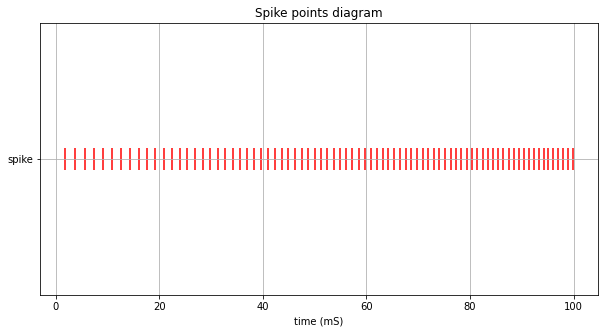

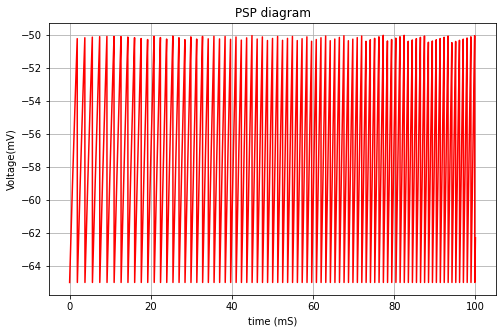

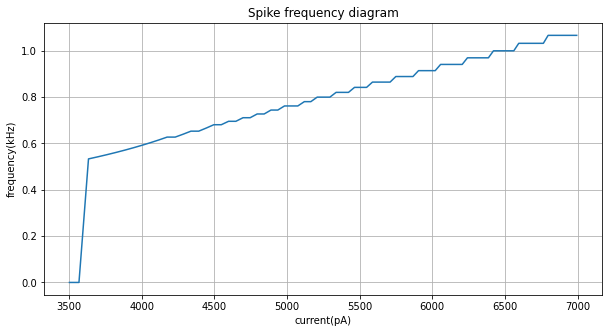

In [35]:
run(data=linear_data, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

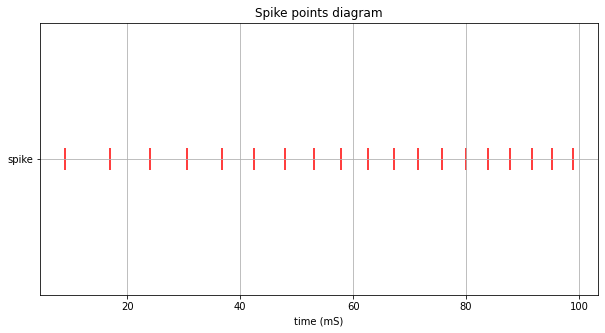

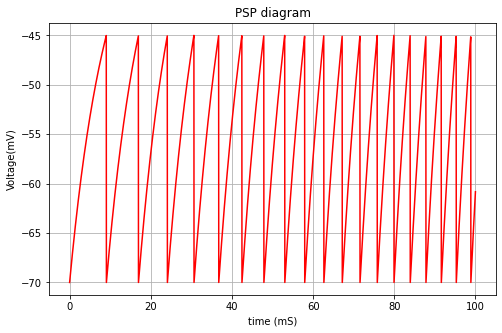

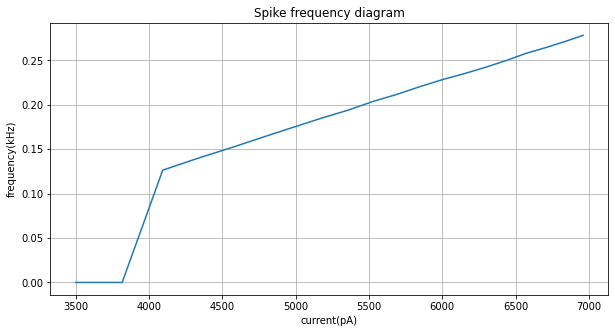

In [36]:
run(data=linear_data, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

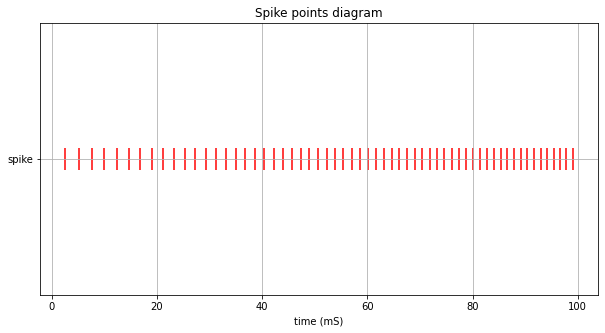

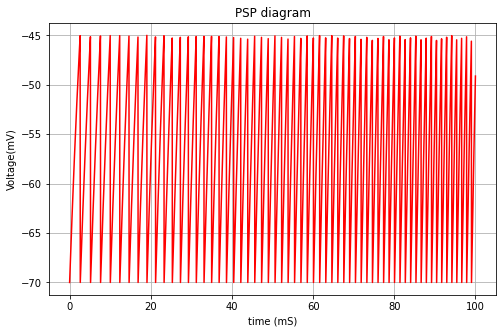

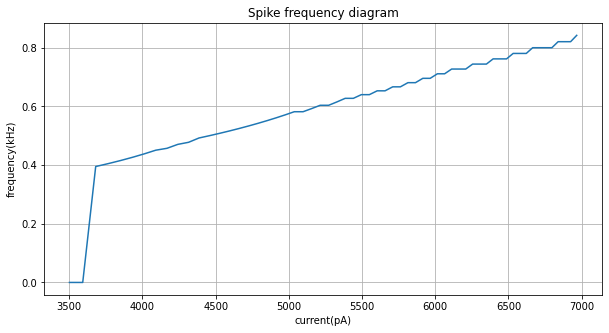

In [37]:
run(data=linear_data, R=0.02, tau=6, u_rest=-70, threshold=-45)

# Linear current with noise

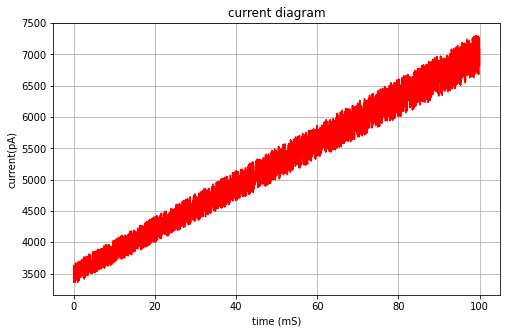

In [38]:
#making a noised floor dataset
noised_data_df = linear_data.copy()
for i in range(len(noised_data_df)):
  noised_data_df[1][i] = noised_data_df[1][i] + random.uniform(-1*(noised_data_df[1][i]*0.05), noised_data_df[1][i]*0.05)
plot_current(noised_data_df)

## R=0.01, tau=8, u_rest=-65, threshold=-50

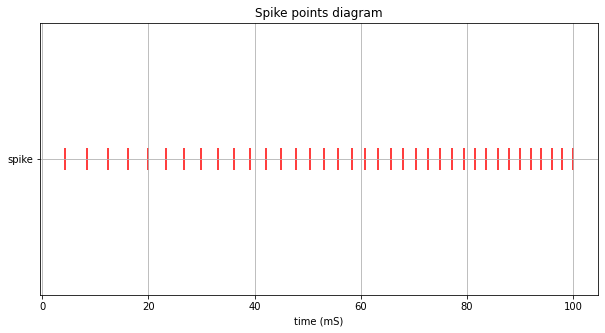

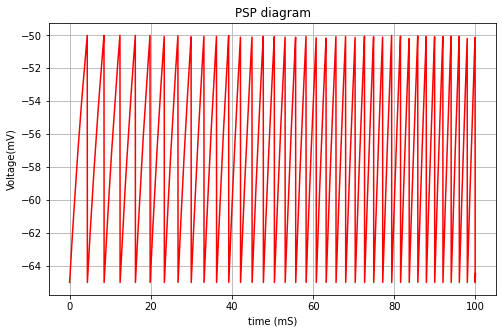

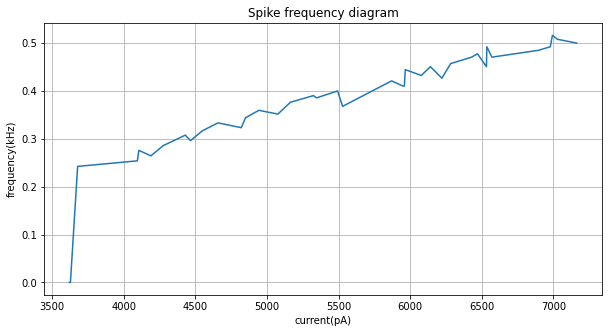

In [39]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

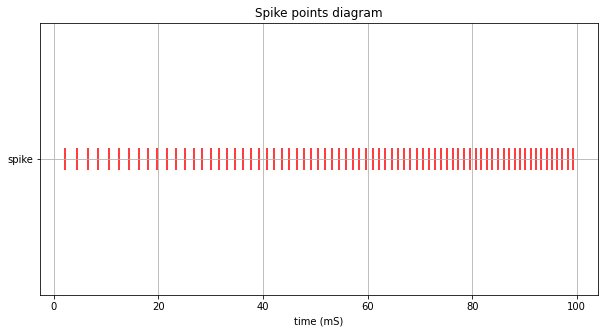

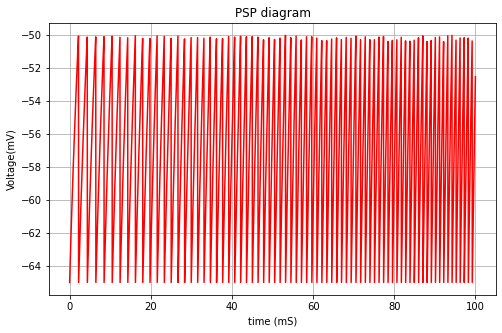

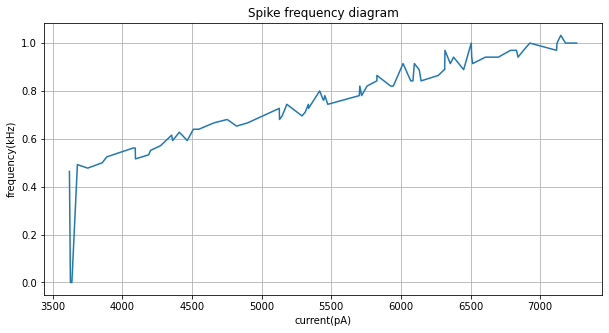

In [40]:
run(data=noised_data_df, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

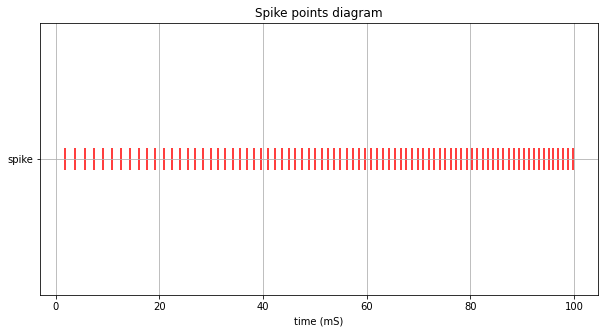

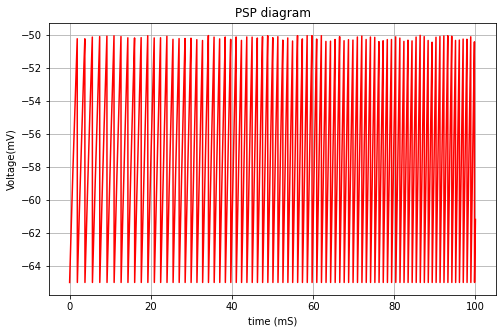

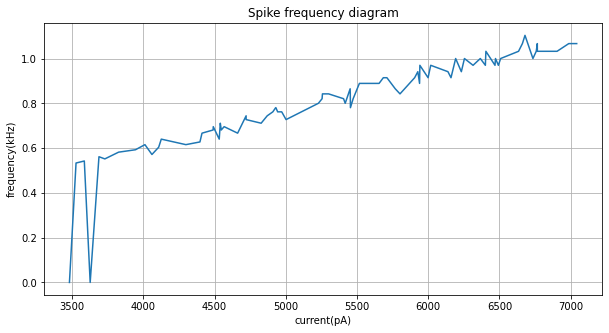

In [41]:
run(data=noised_data_df, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

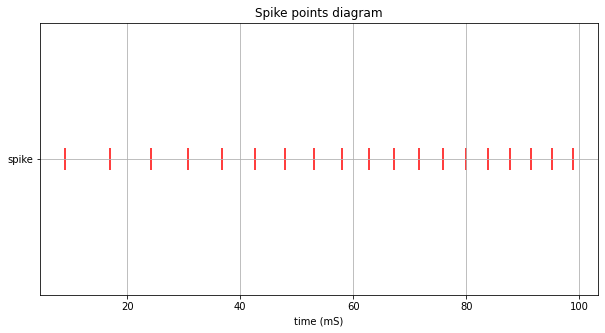

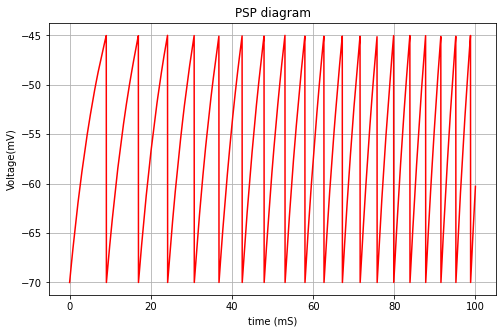

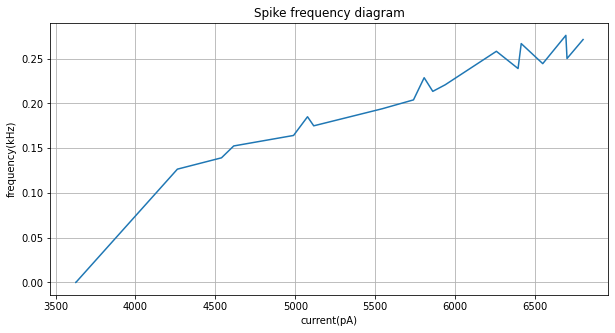

In [42]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

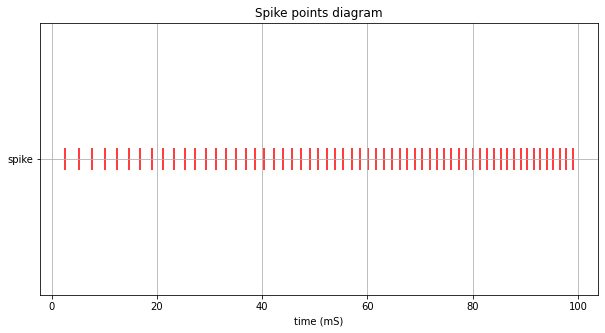

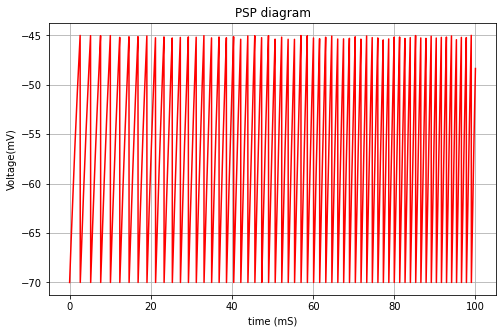

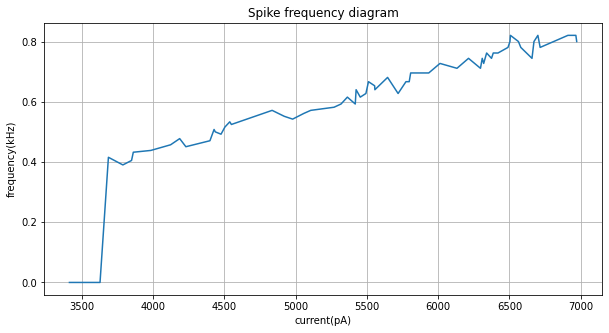

In [43]:
run(data=noised_data_df, R=0.02, tau=6, u_rest=-70, threshold=-45)

# Floor current without noise

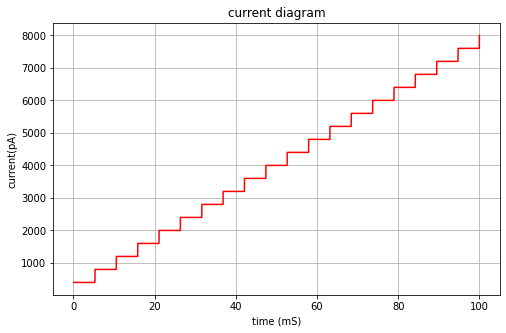

In [44]:
#making a new floor dataset
times = torch.arange(start=0.03125, end=100.0001, step=0.03125)
currents = torch.linspace(1, 20, steps=3200).floor()*400
floor_data = pd.DataFrame([times.numpy(), currents.numpy()]).T
plot_current(floor_data)

## R=0.01, tau=8, u_rest=-65, threshold=-50

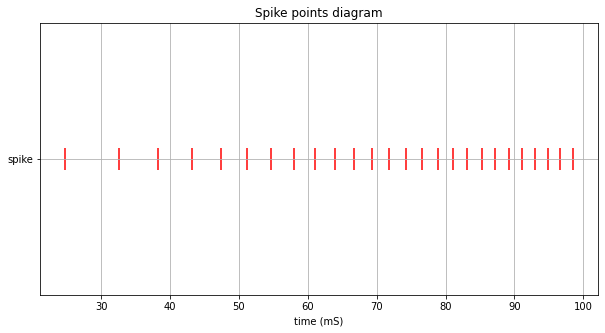

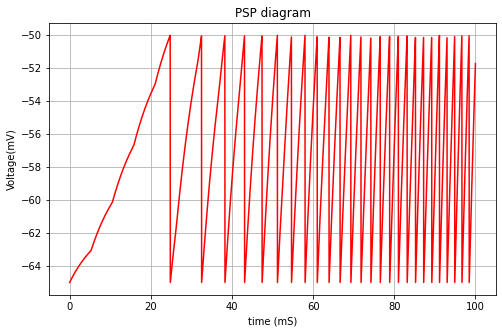

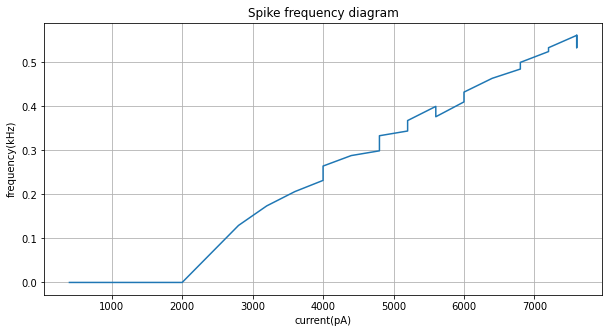

In [45]:
run(data=floor_data, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

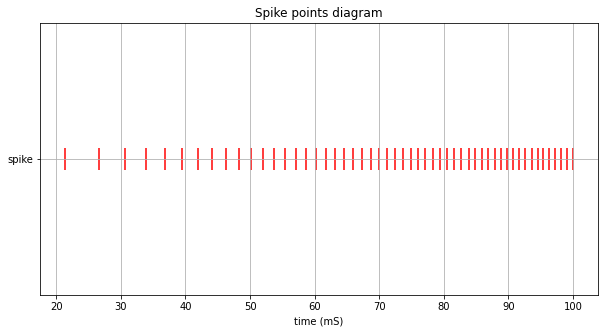

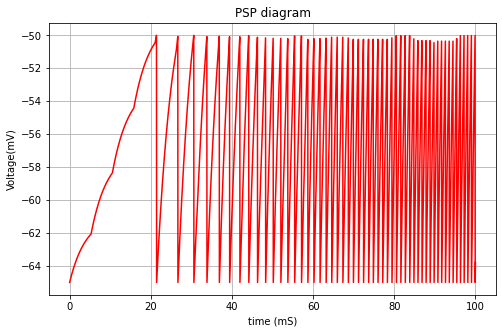

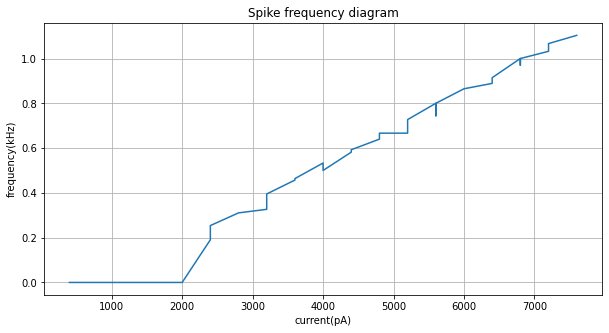

In [46]:
run(data=floor_data, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

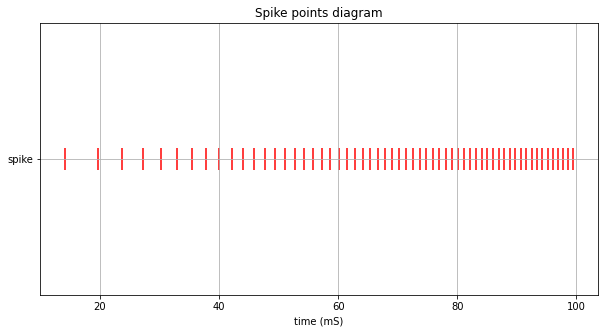

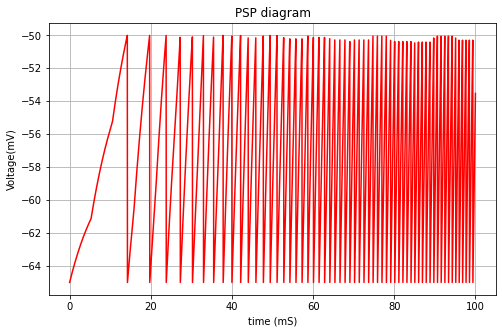

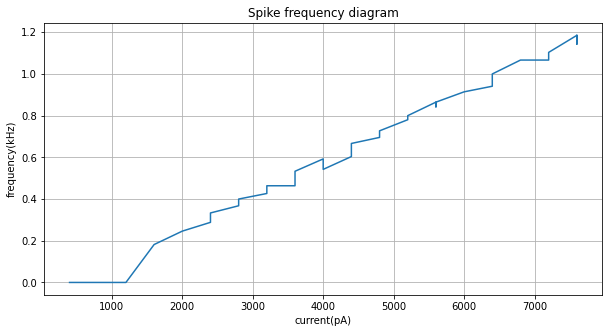

In [47]:
run(data=floor_data, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

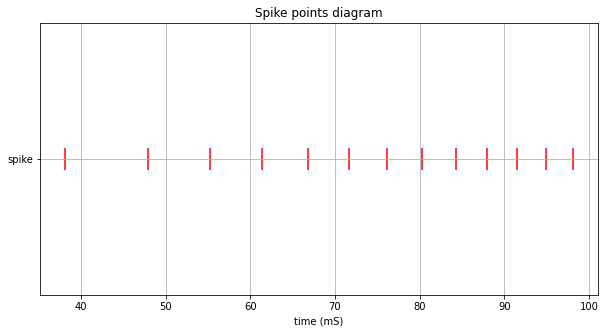

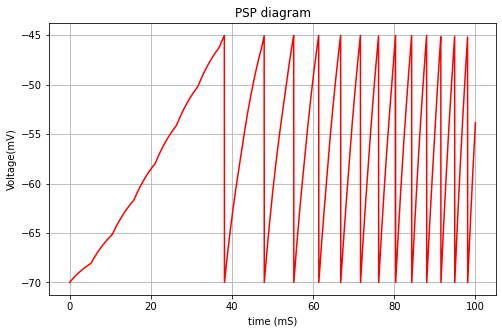

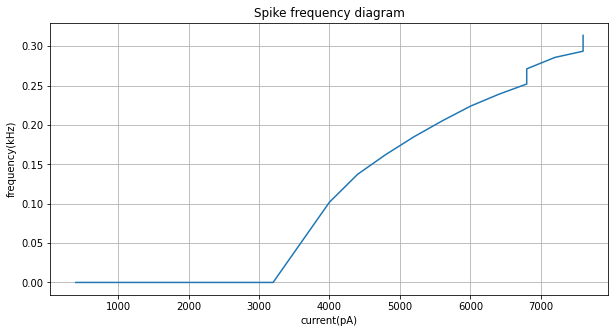

In [48]:
run(data=floor_data, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

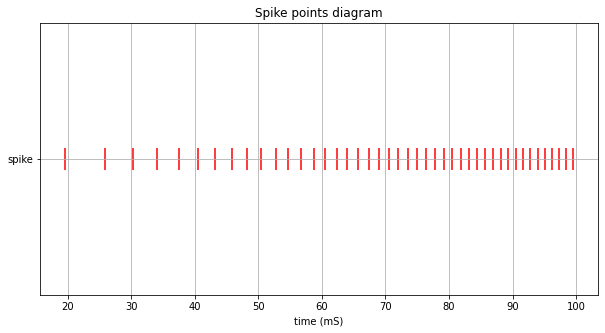

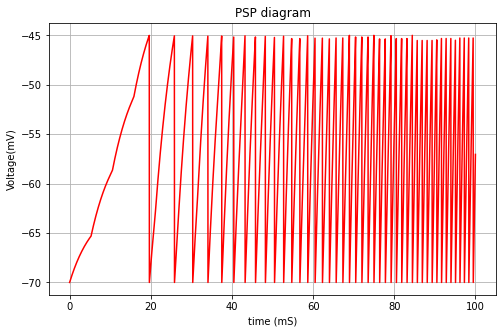

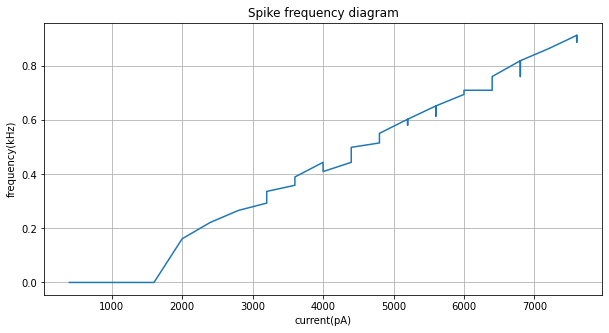

In [49]:
run(data=floor_data, R=0.02, tau=6, u_rest=-70, threshold=-45)

# Floor current with noise

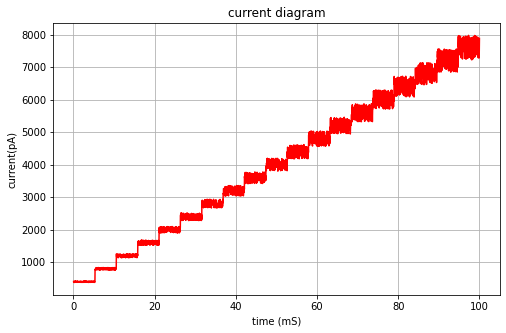

In [50]:
#making a noised floor dataset
noised_data_df = floor_data.copy()
for i in range(len(noised_data_df)):
  noised_data_df[1][i] = noised_data_df[1][i] + random.uniform(-1*(noised_data_df[1][i]*0.05), noised_data_df[1][i]*0.05)
plot_current(noised_data_df)

## R=0.01, tau=8, u_rest=-65, threshold=-50

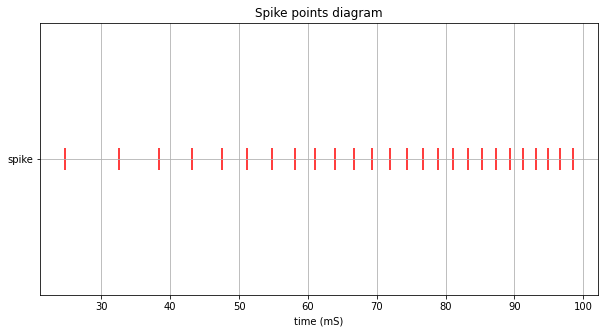

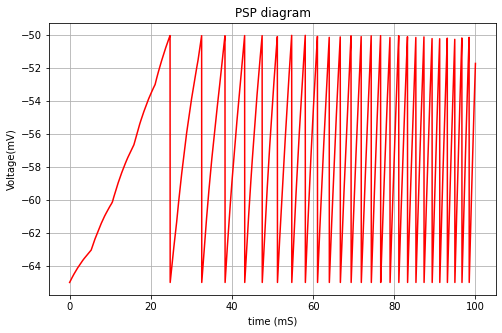

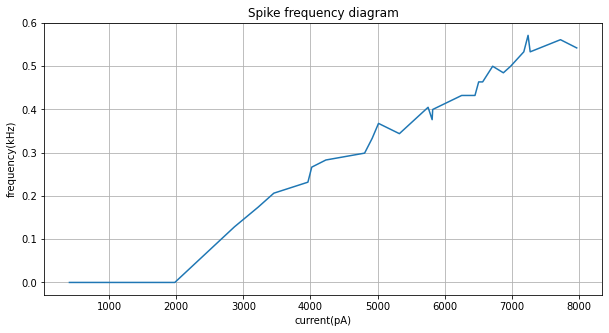

In [51]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

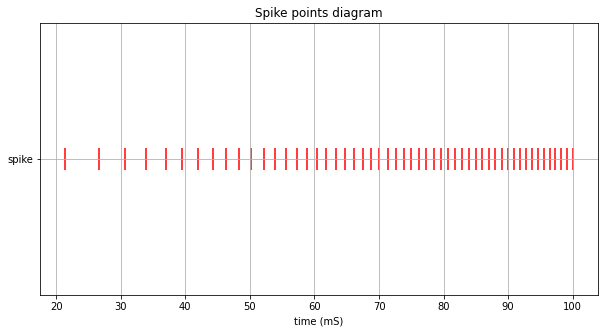

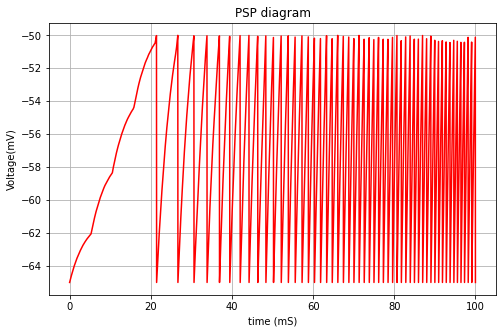

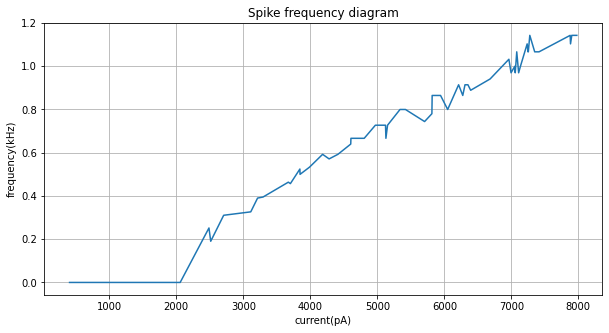

In [52]:
run(data=noised_data_df, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

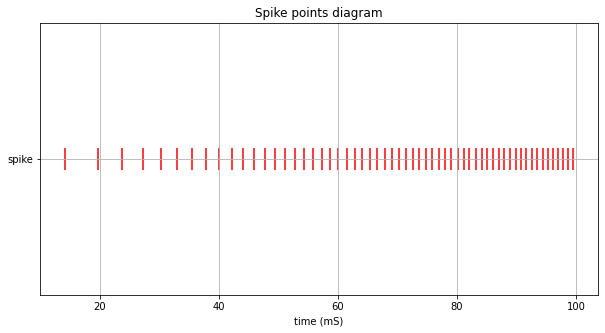

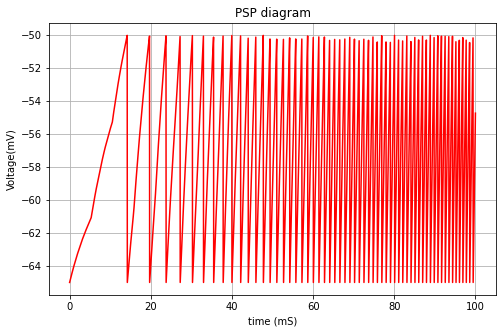

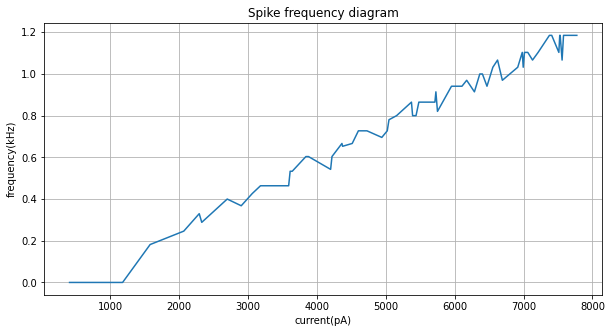

In [53]:
run(data=noised_data_df, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

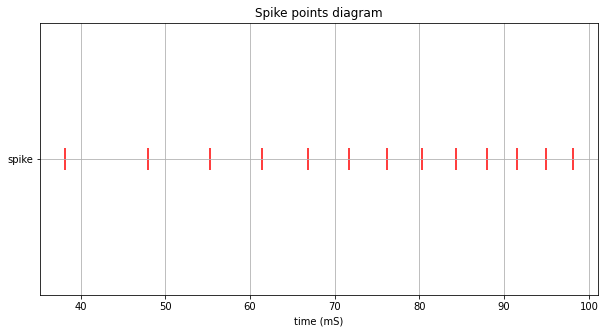

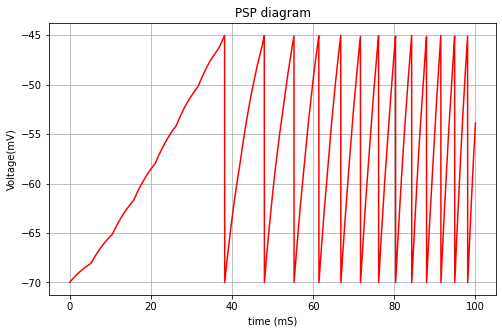

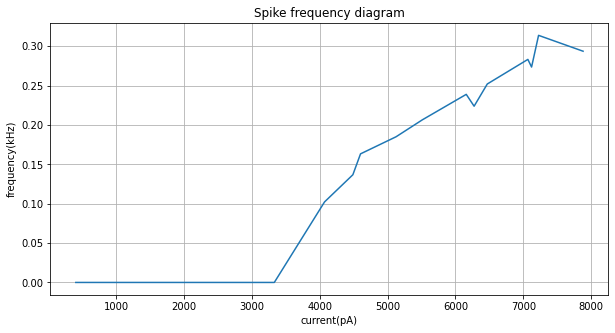

In [54]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

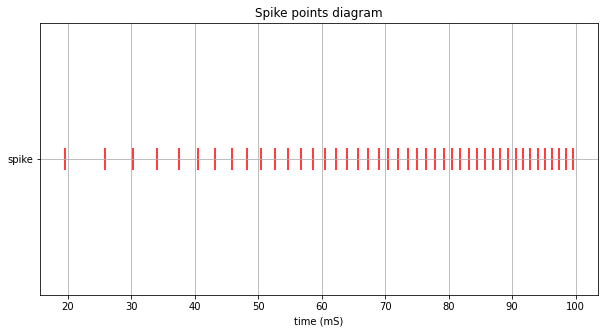

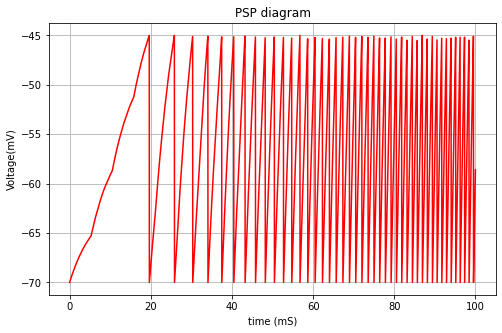

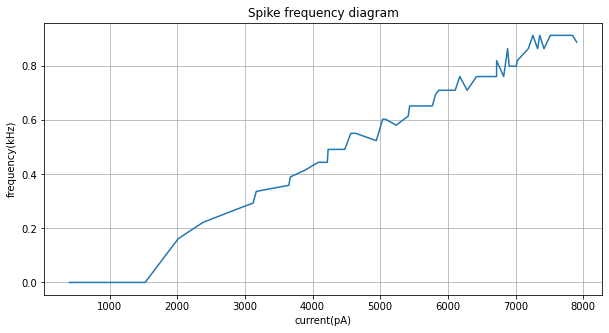

In [55]:
run(data=noised_data_df, R=0.02, tau=6, u_rest=-70, threshold=-45)

# Random current

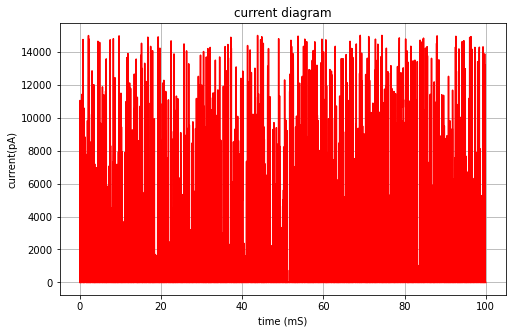

In [56]:
random_data = pd.read_csv('/content/random_current.csv')
random_data.rename(columns={"time(ms)": 0, "current(pA)": 1}, inplace=True)
plot_current(random_data)

## R=0.01, tau=8, u_rest=-65, threshold=-50

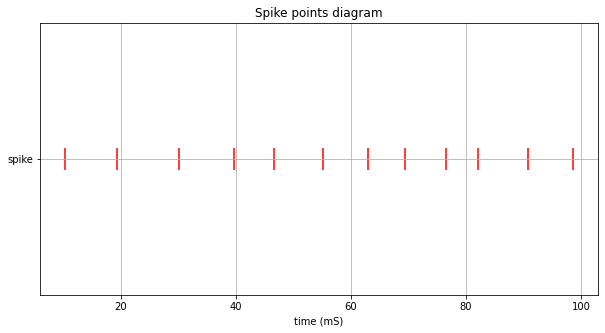

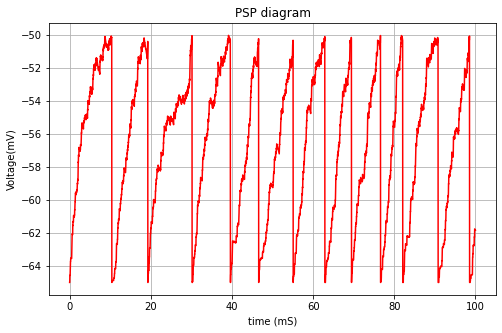

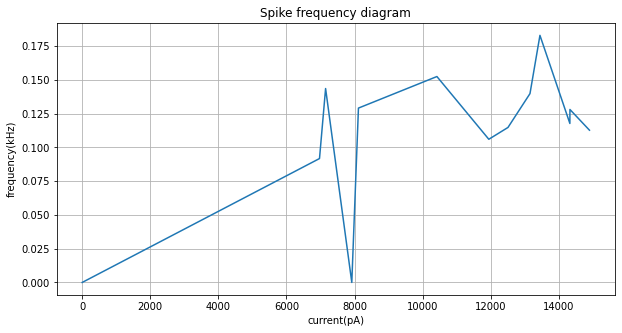

In [57]:
run(data=random_data, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

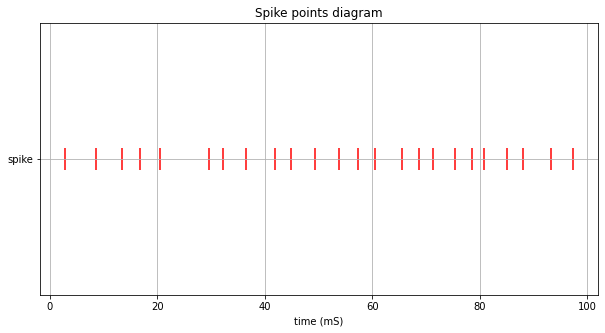

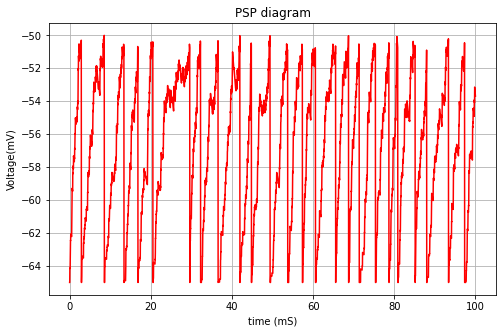

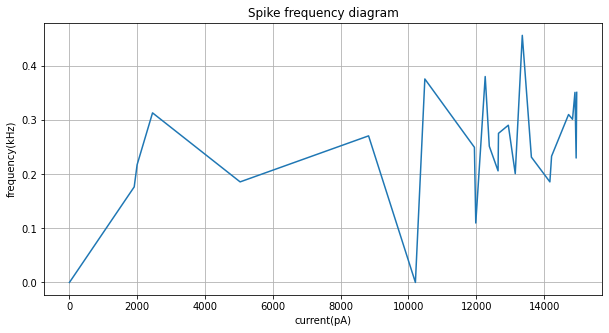

In [58]:
run(data=random_data, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

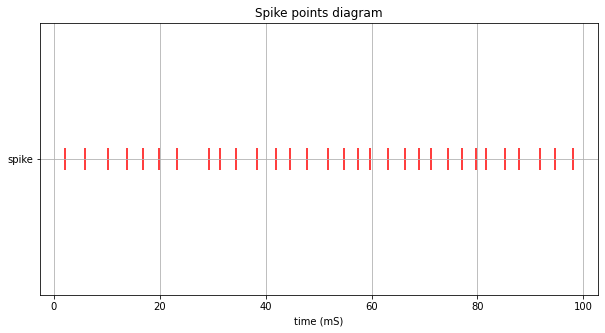

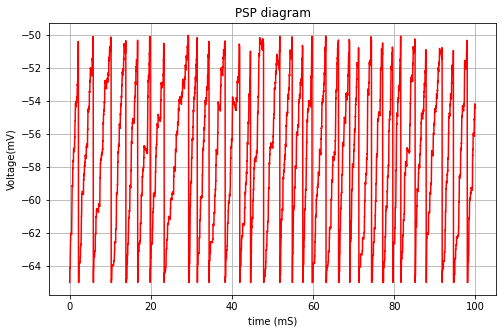

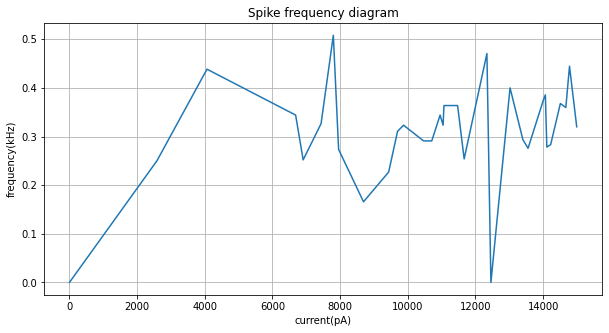

In [59]:
run(data=random_data, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

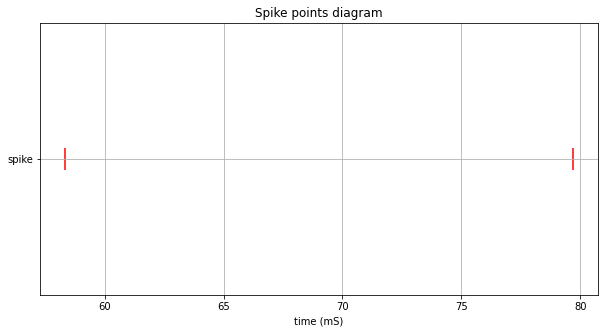

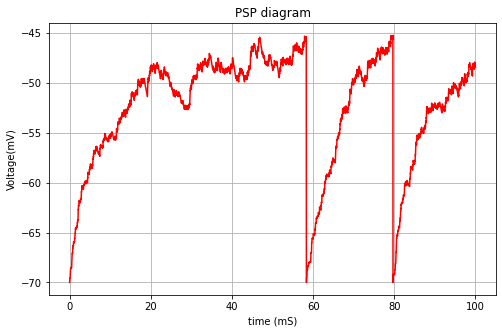

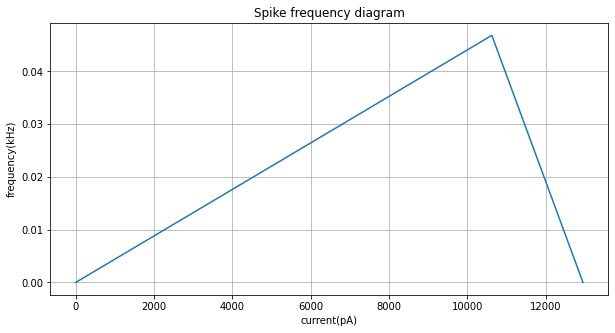

In [60]:
run(data=random_data, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

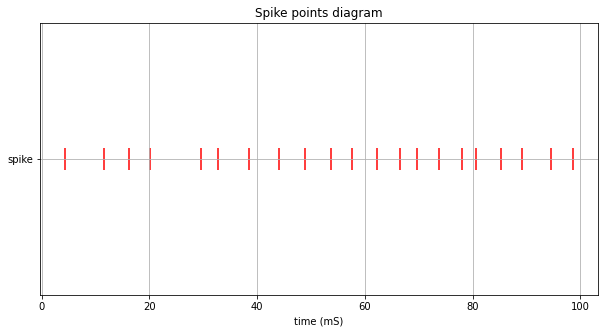

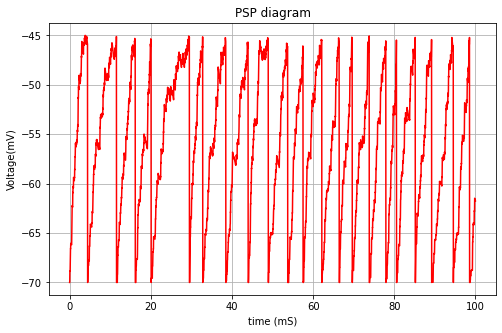

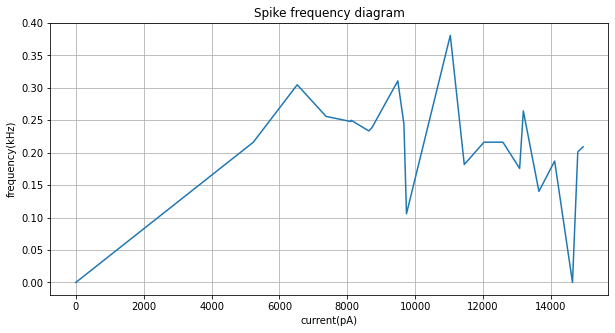

In [61]:
run(data=random_data, R=0.02, tau=6, u_rest=-70, threshold=-45)

# sinusoidal current without noise

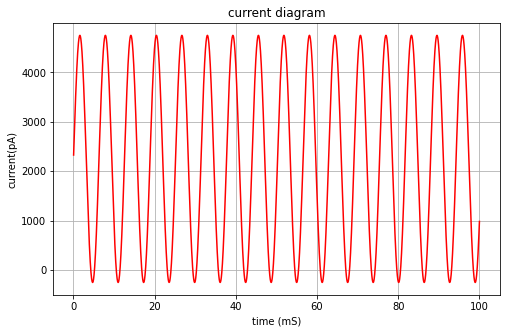

In [62]:
sine_data = pd.read_csv('/content/sine_current.csv')
sine_data.rename(columns={"time(ms)": 0, "current(pA)": 1}, inplace=True)
plot_current(sine_data)

## R=0.01, tau=8, u_rest=-65, threshold=-50

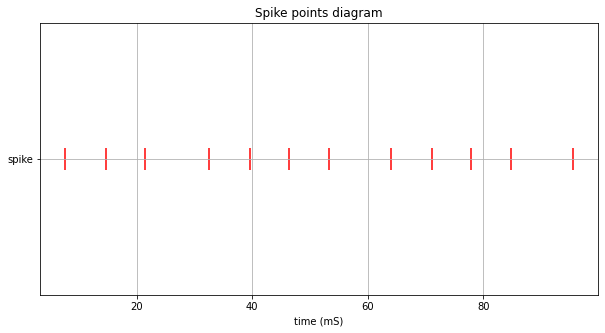

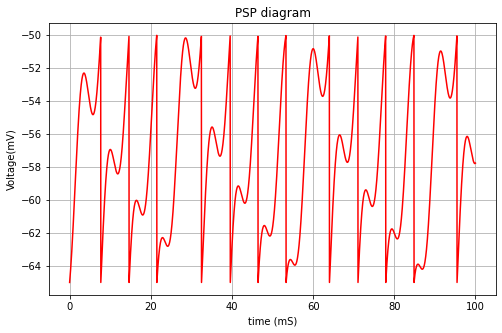

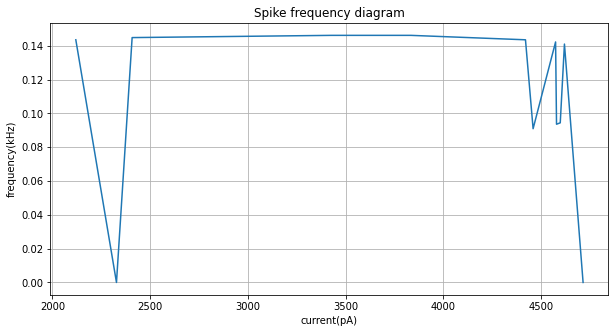

In [63]:
run(data=sine_data, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

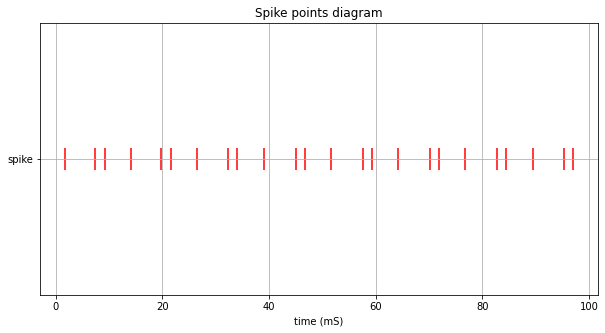

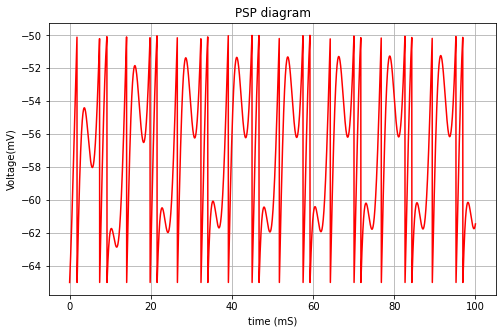

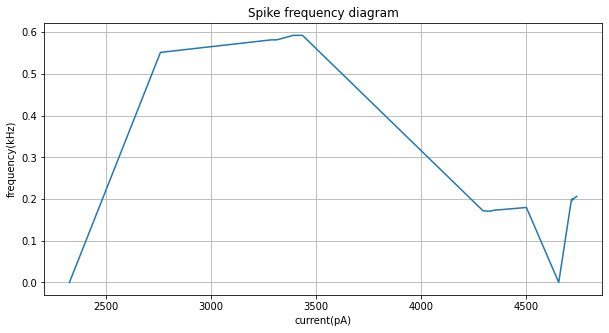

In [64]:
run(data=sine_data, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

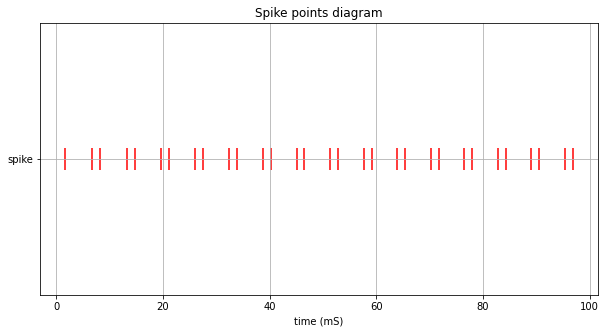

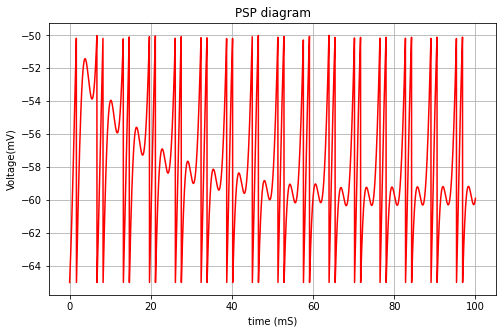

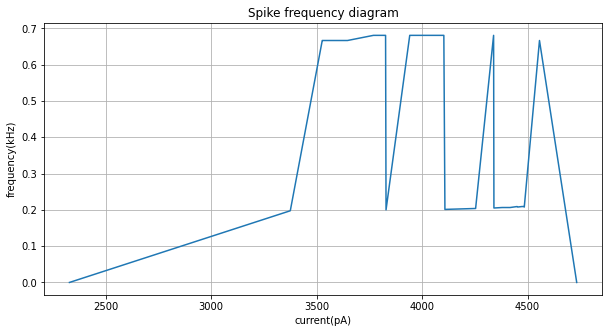

In [65]:
run(data=sine_data, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

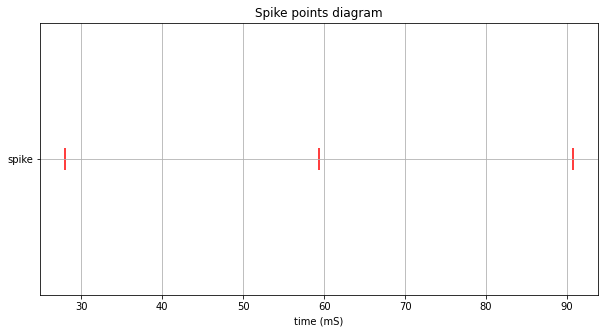

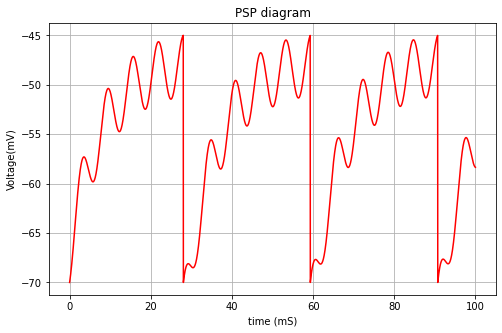

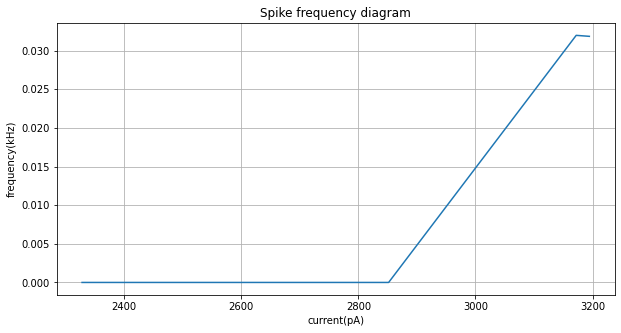

In [66]:
run(data=sine_data, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

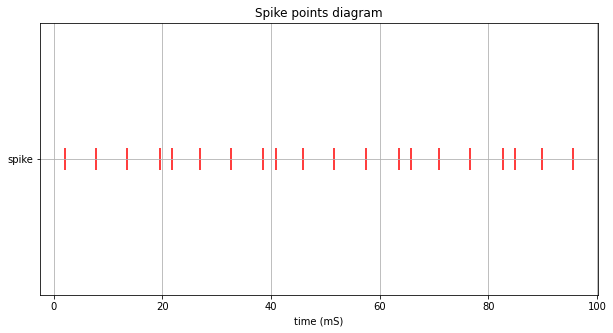

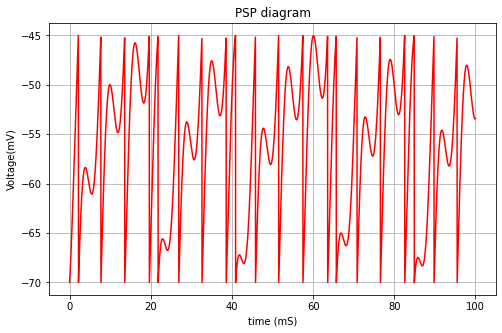

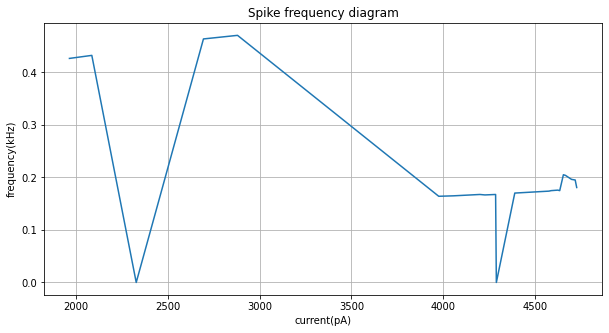

In [67]:
run(data=sine_data, R=0.02, tau=6, u_rest=-70, threshold=-45)

# sinusoidal current with noise

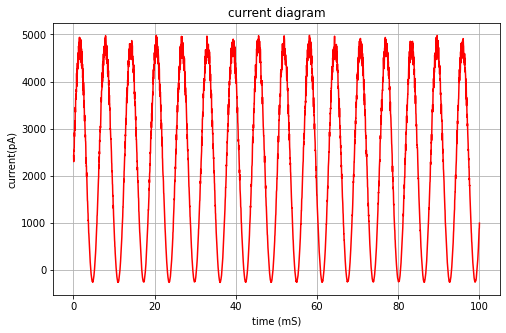

In [68]:
#making a noised floor dataset
noised_data_df = sine_data.copy()
for i in range(len(noised_data_df)):
  noised_data_df[1][i] = noised_data_df[1][i] + random.uniform(-1*(noised_data_df[1][i]*0.05), noised_data_df[1][i]*0.05)
plot_current(noised_data_df)

## R=0.01, tau=8, u_rest=-65, threshold=-50

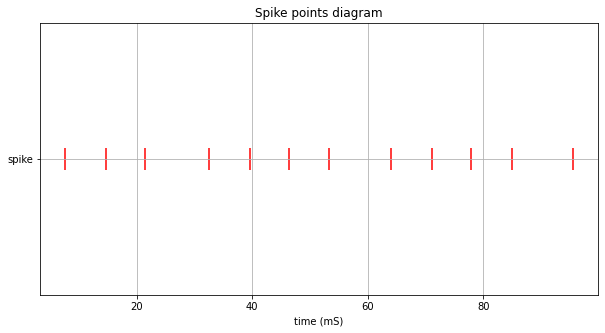

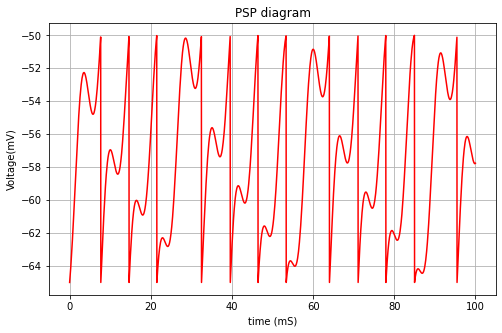

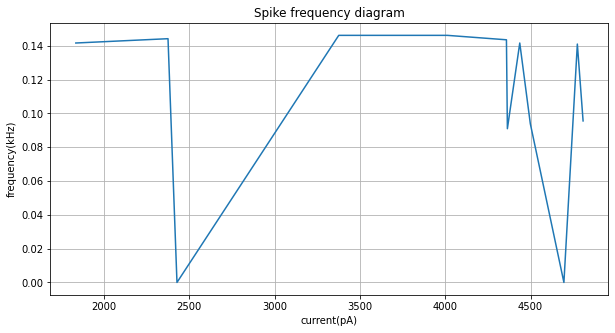

In [69]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=4, u_rest=-65, threshold=-50

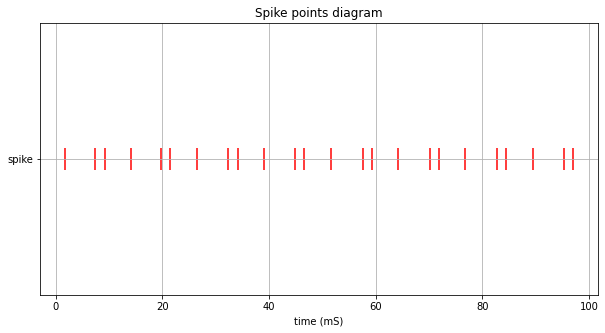

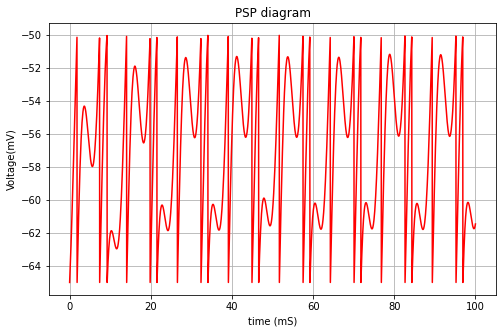

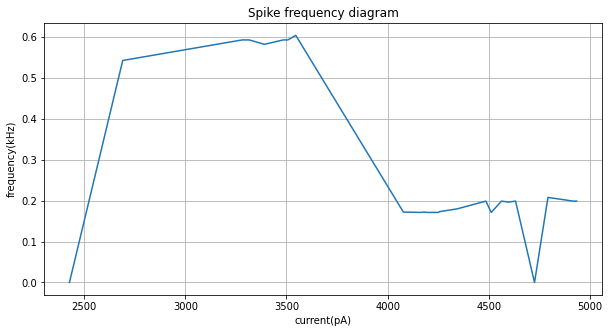

In [70]:
run(data=noised_data_df, R=0.01, tau=4, u_rest=-65, threshold=-50)

## R=0.02, tau=8, u_rest=-65, threshold=-50

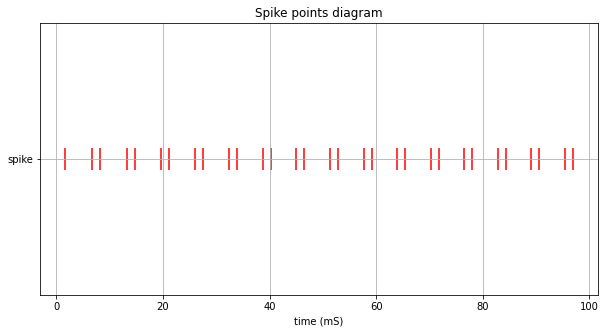

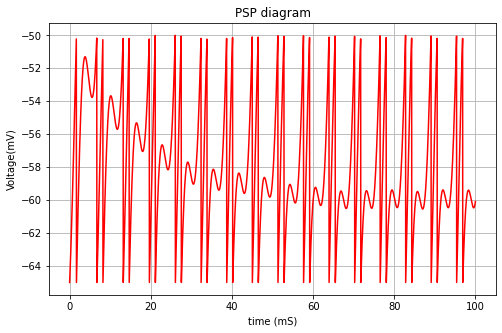

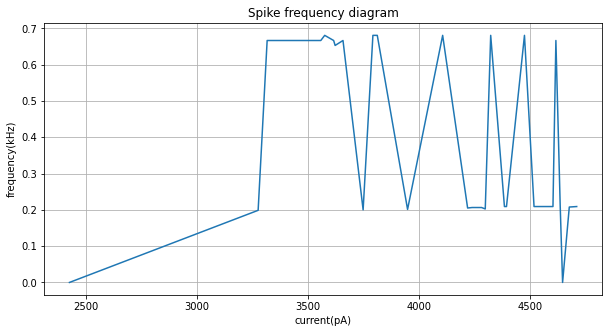

In [71]:
run(data=noised_data_df, R=0.02, tau=8, u_rest=-65, threshold=-50)

## R=0.01, tau=8, u_rest=-70, threshold=-45

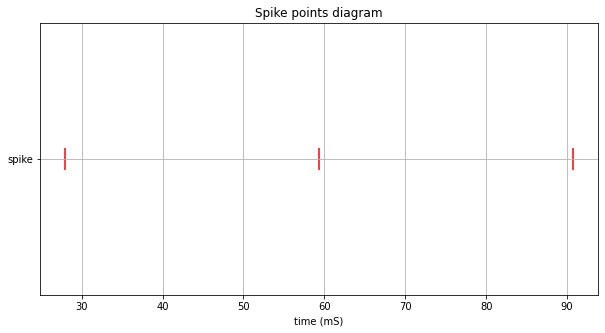

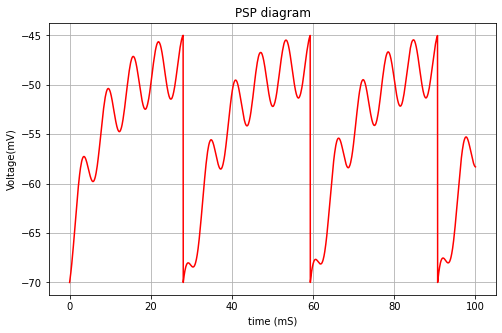

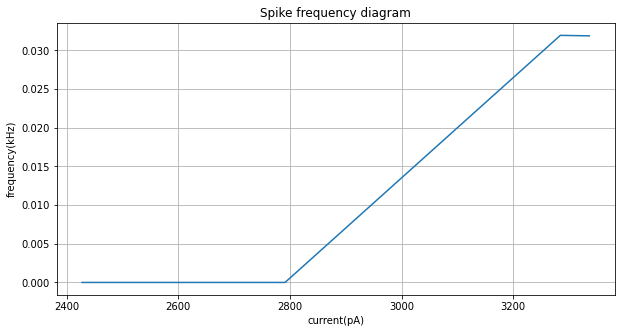

In [72]:
run(data=noised_data_df, R=0.01, tau=8, u_rest=-70, threshold=-45)

## R=0.02, tau=6, u_rest=-70, threshold=-45

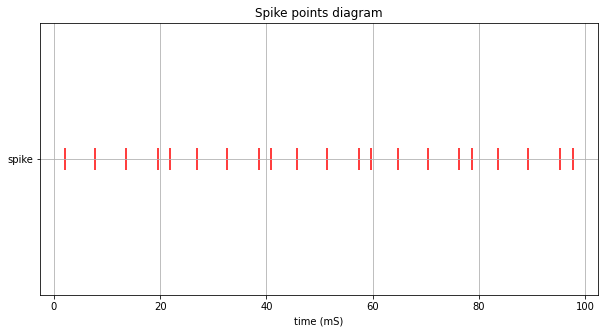

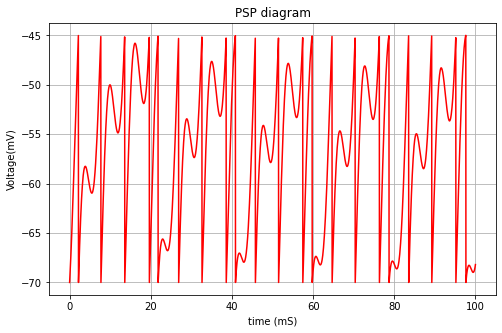

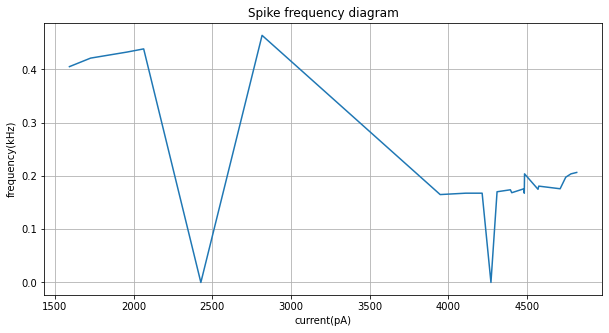

In [73]:
run(data=noised_data_df, R=0.02, tau=6, u_rest=-70, threshold=-45)